# 3.4 次元削減、特徴量抽出、多様体学習

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
from sklearn.model_selection import train_test_split
%matplotlib notebook
%matplotlib inline

## 3.4.1 主成分分析(PCA)
教師なし学習を用いたデータ変換の動機には、可視化・データ圧縮・以降の処理に適した表現の発見  
これら全ての目的に対して最もよく用いられるアルゴリズムが主成分分析(PCA)  
主成分分析 : データセットの特注量を相互に統計的に関連しないように回転する方法、回転したあとの特徴量からデータを説明するのに重要な一部の特徴量だけを抜き出す

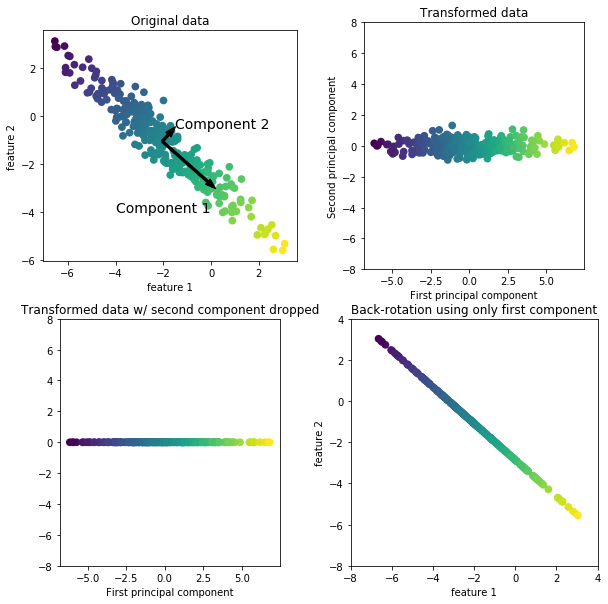

In [6]:
'''
PCAを合成2次元データセットに適用した例
Original data : 
最も分散が大きい方向を見つけ、それに「第1成分(Compoent 1)」というラベルを付ける
Transformed data : 
第1主成分がx軸に沿い、第2主成分がy軸に沿うように回転したもの
Transformed data w/ second component dropped : 
変換して第2主成分を落としたデータ、第1主成分だけ残ったもの
Back-rotation using only first component : 
第1主成分のデータのみを、元の特徴量空間に戻したもの、データからノイズが取り除かれている
'''

mglearn.plots.plot_pca_illustration()

### 3.4.1.1 cancerデータセットのPCAによる可視化

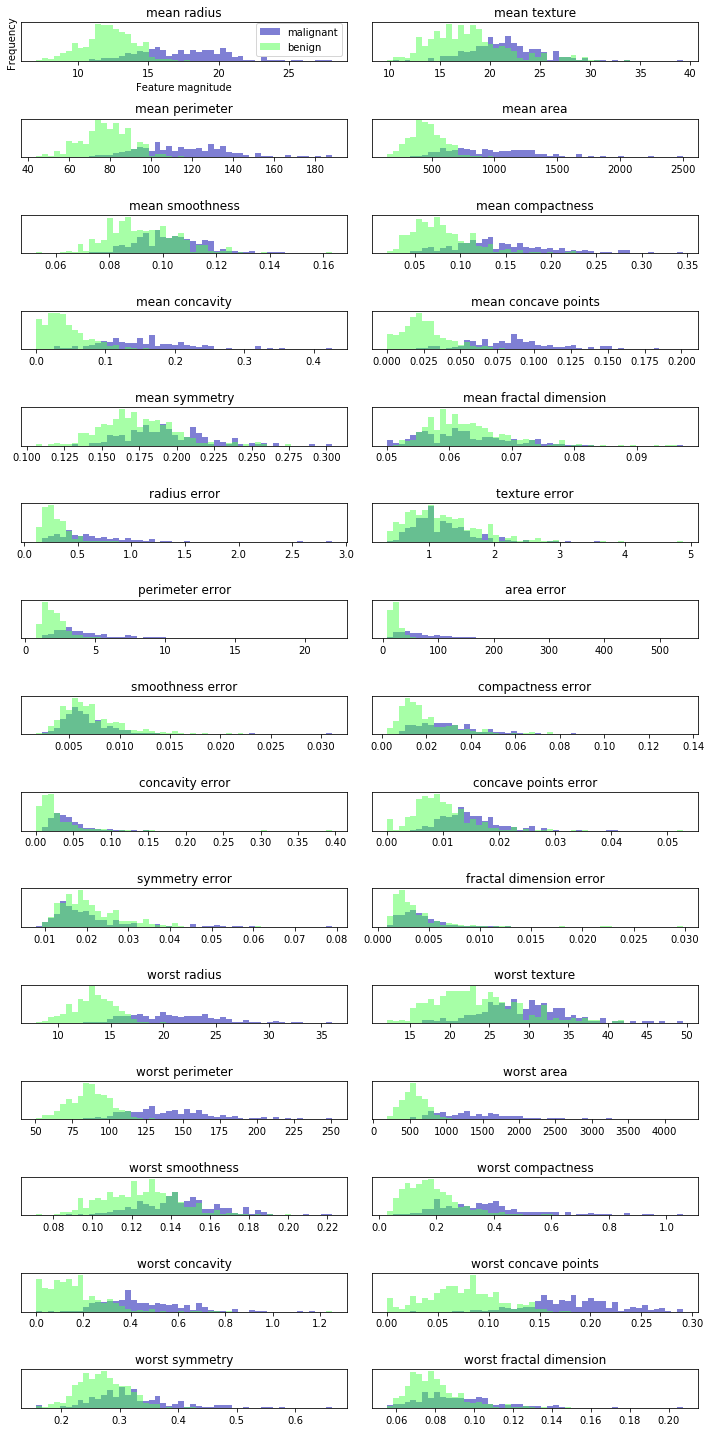

In [10]:
'''
cancerデータセットの特徴量(30)ごとに2つのクラスのヒストグラムを作成
良性(benign)は緑色、悪性(malignant)は青色
個々の特徴量の2つのクラスに対する分布がわかり、どの特徴量が良性と悪性を見分けるのに役立つか
'''

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())

ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

In [12]:
'''
PCAを用いて、↑の主な相関を捉える
PCAを適用する前にデータをスケール変換し、個々の特徴量の分散が1になるようにする
'''

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [15]:
'''
デフォルトでは、PCAメソッドはデータの回転しか行わず、全ての主成分を維持する
次元削減を行うために、PCAオブジェクトを生成する際にn_componentsパラメータで指定する
今回は最初の2つの主成分のみを用いる
'''

from sklearn.decomposition import PCA

# データの最初の2つの主成分だけ維持する
pca = PCA(n_components=2)
# cancerデータセットにPCAモデルを適合
pca.fit(X_scaled)

# 最初の2つの主成分に対してデータポイントを変換
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


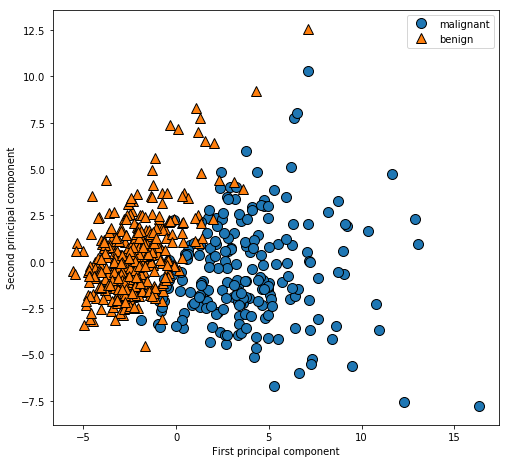

In [16]:
'''
2つの主成分に対してプロット
この分布の仕方を見ると、線形クラス分類器でもそれなりに分類できそうだとわかる
悪性のデータポイントは良性のデータポイントよりも広がっていることもわかる
'''

# 第1種成分と第2主成分によるプロット。クラスごとに色分け
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [17]:
'''
主成分は、PCAの適合を行う過程で、components_属性に格納される
'''

print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


In [21]:
'''
components_のそれぞれの行が1つの主成分
行は重要度によってソートされている（第1主成分が最初）
列は、PCA変換する前の元の特徴量に対応
'''

print("PCA components \n{}".format(pca.components_.round(3)))

PCA components 
[[ 0.219  0.104  0.228  0.221  0.143  0.239  0.258  0.261  0.138  0.064
   0.206  0.017  0.211  0.203  0.015  0.17   0.154  0.183  0.042  0.103
   0.228  0.104  0.237  0.225  0.128  0.21   0.229  0.251  0.123  0.132]
 [-0.234 -0.06  -0.215 -0.231  0.186  0.152  0.06  -0.035  0.19   0.367
  -0.106  0.09  -0.089 -0.152  0.204  0.233  0.197  0.13   0.184  0.28
  -0.22  -0.045 -0.2   -0.219  0.172  0.144  0.098 -0.008  0.142  0.275]]


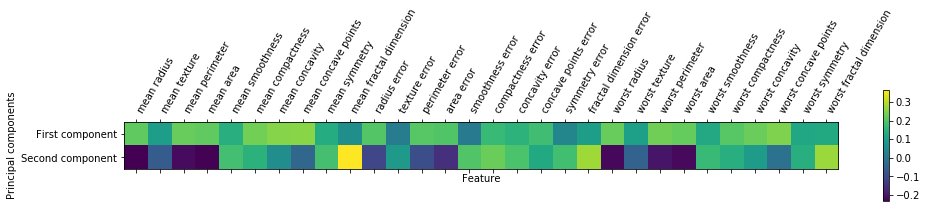

In [22]:
'''
係数をヒートマップでみる
2主成分のヒートマップ
'''

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
                  cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

### 3.4.1.2 固有顔に寄る特徴量抽出